In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
import stable_baselines3
from portfolio_env_framework import *
import random
import torch
import torch.nn as nn
import numpy.typing as npt
import gymnasium as gym

## Test

In [20]:
class BasicDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.vol_20 = idx_df.vol_20
        self.vol_60 = idx_df.vol_60
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix_df = vix_df.vix
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = w
        # s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[1:, :-1] = self.ret.loc[self.times[t:t+100], :].to_numpy().T # 100 past returns, up to yesterday
        s[-1, 1] = self.vol_20[self.times[t+100-1]] # yesterday's vol_20
        s[-1, 2] = self.vol_20[self.times[t+100-1]] / self.vol_60[self.times[t+100-1]] # yesterday's vol ratio
        s[-1, 3] = self.vix_df[self.times[t+100-1]] # yesterday's vix
        return s

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_df.loc[self.times[t+100], :].to_numpy().flatten(), 1.0)

In [21]:
class DifferentialSharpeRatioReward(AbstractRewardManager):
    def __init__(self, eta: float = 1/252):
        self.eta = eta
        self.initialize_reward()

    def initialize_reward(self):
        self.A, self.B = 0.0, 0.0

    def compute_reward(self, old_port_val: float, new_port_val: float) -> float:
        R = np.log(new_port_val / old_port_val)
        dA = R - self.A
        dB = R ** 2 - self.B
        if self.B - self.A ** 2 == 0:
            D = 0
        else:
            D = (self.B * dA - 0.5 * self.A * dB) / (self.B - self.A ** 2) ** (3 / 2)
        self.A += self.eta * dA
        self.B += self.eta * dB
        return D

In [22]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': BasicDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework")

KeyboardInterrupt: 

In [ ]:
class TestBasicDataManager(AbstractDataManager):
    def get_obs_space(self) -> gym.spaces.Box:
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.universe_size+1, 100+1), dtype=np.float32)

    def get_data(self) -> tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()
        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        # assert np.all(self.stock_df.pct_change().iloc[1:, :] > -1), f"{(self.stock_df.pct_change().iloc[1:, :] <= -1).sum().sum()=}, {np.any(pd.isna(self.stock_df.pct_change().iloc[1:, :]))}"
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
    
        # get times and dickers
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()
    
        # read index data and compute volatilities
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df
        self.vol_20 = idx_df.vol_20
        self.vol_60 = idx_df.vol_60
    
        # get vix data
        vix_df = pd.read_csv('crsp_vix_2010_to_2024.csv', dtype={
          'Date': 'string',
          'vix': float
        })
        vix_df.Date = pd.to_datetime(vix_df.Date)
        vix_df.set_index('Date', inplace=True)
        self.vix_df = vix_df.vix
        
        self.num_time_periods = len(self.times)-100-1
        self.universe_size = len(self.tickers)
        return self.num_time_periods, self.universe_size
    
    def get_state(self, t: int, w: npt.NDArray[np.float64], port_val: np.float64) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        s = np.zeros((self.universe_size+1, 100+1))
        s[:, 0] = w
        # s[1:, :-1] = self.ret[self.t:self.t+100, :].T
        s[1:, :-1] = self.ret.loc[self.times[t:t+100], :].to_numpy().T # 100 past returns, up to yesterday
        s[-1, 1] = self.vol_20[self.times[t+100-1]] # yesterday's vol_20
        s[-1, 2] = self.vol_20[self.times[t+100-1]] / self.vol_60[self.times[t+100-1]] # yesterday's vol ratio
        s[-1, 3] = self.vix_df[self.times[t+100-1]] # yesterday's vix
        return s

    def get_prices(self, t: int) -> npt.NDArray[np.float64]:
        # today is self.times[self.t+100]
        return np.append(self.stock_df.loc[self.times[t+100], :].to_numpy().flatten(), 1.0)

In [ ]:
env = PortfolioEnvWithTCost(dm=TestBasicDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.10/365, cs=0.10/365)
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+100]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+100])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+100]].vwretd.values[0]))
    if terminated:
        break

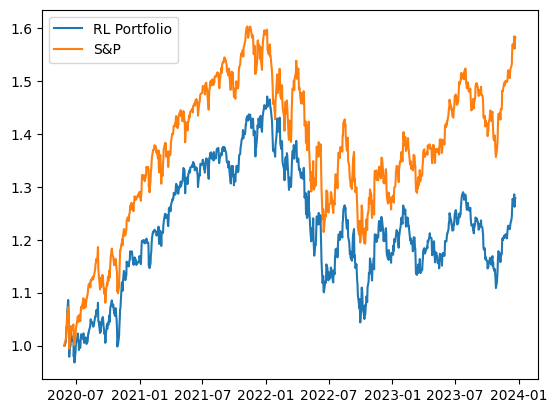

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
min(mus), max(mus)

(0.9995167124420706, 0.9998240884067789)

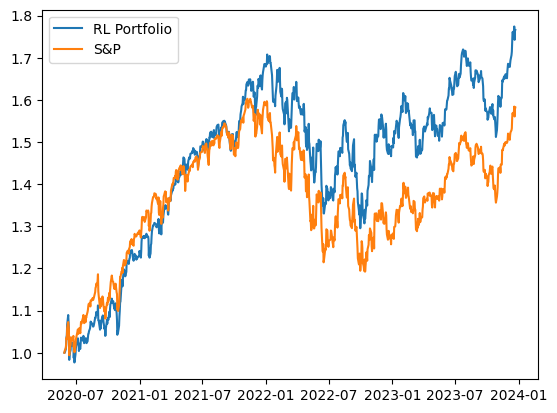

In [ ]:
plt.plot(times_arr, np.array(port_val) / np.array([1, *mus]).cumprod(), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## Model Softmax

In [ ]:
# Parallel environments
vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': BasicDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
torch.manual_seed(42)

class SoftmaxActivation(nn.Module):
  def __init__(self):
    super().__init__()
    self.activation = nn.Softmax(dim=1)
  
  def forward(self, x):
    return self.activation(x)

model = PPO("MlpPolicy", vec_env, verbose=1, policy_kwargs=dict(activation_fn=SoftmaxActivation))
model.learn(total_timesteps=100_000)
model.save("tcost_portfolio_rl_model_framework_softmax")

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 465  |
|    iterations      | 1    |
|    time_elapsed    | 17   |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.41e+03    |
|    ep_rew_mean          | 6.54e+03    |
| time/                   |             |
|    fps                  | 381         |
|    iterations           | 2           |
|    time_elapsed         | 42          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011069694 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 2.34        |
|    n_updates            | 10          |
|    policy_grad

In [ ]:
env = PortfolioEnvWithTCost(dm=TestBasicDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.10/365, cs=0.10/365)
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.dm.times[env.t+100]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.dm.times[env.t+100])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.dm.idx_df[env.dm.idx_df.index == env.dm.times[env.t+100]].vwretd.values[0]))
    if terminated:
        break

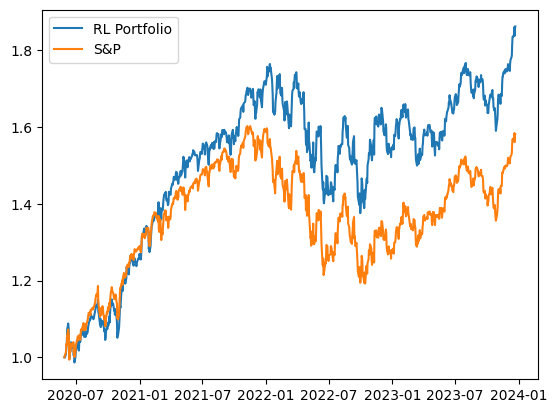

In [ ]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

## Training Curves

In [ ]:
# Parallel environments
import stable_baselines3.common
import stable_baselines3.common.logger


vec_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': BasicDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})
eval_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
  'dm': TestBasicDataManager(),
  'rm': DifferentialSharpeRatioReward(),
  'cp': 0.10/365,
  'cs': 0.10/365
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(43)
eval_env.seed(42)
eval_env.action_space.seed(43)
torch.manual_seed(42)

eval_callback = EvalCallback(eval_env, log_path="./logs", eval_freq=10_000)

class SoftmaxActivation(nn.Module):
  def __init__(self):
    super().__init__()
    self.activation = nn.Softmax(dim=1)
  
  def forward(self, x):
    return self.activation(x)

model = PPO("MlpPolicy", vec_env, verbose=1, policy_kwargs=dict(activation_fn=SoftmaxActivation))
model.set_logger(stable_baselines3.common.logger.configure('./logs', ['csv', 'stdout']))
model.learn(total_timesteps=50_000, callback=eval_callback)
model.save("tcost_portfolio_rl_model_framework_softmax")

Using cuda device
Logging to ./logs
-----------------------------
| time/              |      |
|    fps             | 376  |
|    iterations      | 1    |
|    time_elapsed    | 21   |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.41e+03    |
|    ep_rew_mean          | 6.54e+03    |
| time/                   |             |
|    fps                  | 290         |
|    iterations           | 2           |
|    time_elapsed         | 56          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011069694 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -121        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 2.34        |
|    n_updates            | 10          

In [ ]:
progress = pd.read_csv('./logs/progress.csv')

In [ ]:
progress['eval/mean_reward']

0          NaN
1          NaN
2          NaN
3          NaN
4   -21.127969
5          NaN
6          NaN
7          NaN
Name: eval/mean_reward, dtype: float64

In [ ]:
progress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   time/time_elapsed           7 non-null      float64
 1   time/total_timesteps        8 non-null      int64  
 2   time/fps                    7 non-null      float64
 3   time/iterations             7 non-null      float64
 4   train/value_loss            6 non-null      float64
 5   train/entropy_loss          6 non-null      float64
 6   train/loss                  6 non-null      float64
 7   train/policy_gradient_loss  6 non-null      float64
 8   train/learning_rate         6 non-null      float64
 9   train/explained_variance    6 non-null      float64
 10  train/approx_kl             6 non-null      float64
 11  train/clip_fraction         6 non-null      float64
 12  rollout/ep_len_mean         6 non-null      float64
 13  train/std                   6 non-null 

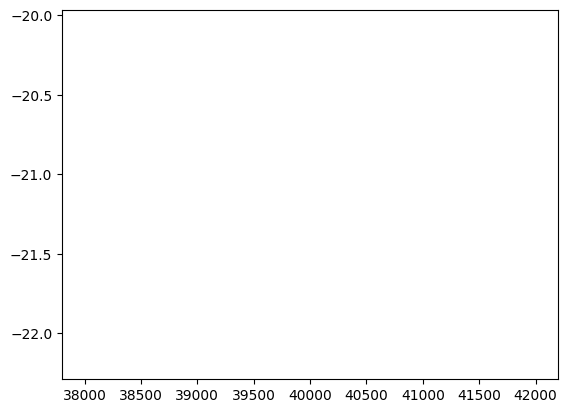

In [ ]:
plt.plot(progress['time/total_timesteps'], progress['eval/mean_reward'])
plt.show()

## More Eval

In [ ]:
# Parallel environments
import stable_baselines3.common
import stable_baselines3.common.logger


train_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
    'dm': BasicDataManager(),
    'rm': DifferentialSharpeRatioReward(),
    'cp': 0.10/365,
    'cs': 0.10/365
})
# eval_env = make_vec_env(PortfolioEnvWithTCost, n_envs=4, env_kwargs={
#   'dm': TestBasicDataManager(),
#   'rm': DifferentialSharpeRatioReward(),
#   'cp': 0.10/365,
#   'cs': 0.10/365
# })
eval_env = PortfolioEnvWithTCost(dm=TestBasicDataManager(), rm=DifferentialSharpeRatioReward(), cp=0.10/365, cs=0.10/365)

# Set seeds
random.seed(42)
np.random.seed(42)
train_env.seed(42)
train_env.action_space.seed(43)
# eval_env.seed(42)
# eval_env.action_space.seed(43)
torch.manual_seed(42)

class SoftmaxActivation(nn.Module):
  def __init__(self):
    super().__init__()
    self.activation = nn.Softmax(dim=1)
  
  def forward(self, x):
    return self.activation(x)
model = PPO("MlpPolicy", train_env, verbose=1, policy_kwargs=dict(activation_fn=SoftmaxActivation))

Using cuda device


In [ ]:
log = []

for iteration in range(100):
    # learn
    print(f"Iteration {iteration}")
    if iteration == 0:
        model.learn(8000)
    else:
        model.learn(8000, reset_num_timesteps=False)

    # initialize
    obs, _ = eval_env.reset()
    port_val = [1.0]
    snp_val = [1.0]
    actions = []
    ys = []
    times_arr = [eval_env.dm.times[eval_env.t+100]]
    mus = []

    # run eval
    for i in range(900):
        action, _ = model.predict(obs, deterministic=True)
        actions.append(action)
        obs, rewards, terminated, truncated, info = eval_env.step(action)
        ys.append(eval_env.y)
        mus.append(eval_env.mu)
        times_arr.append(eval_env.dm.times[eval_env.t+100])
        port_val.append(info['port_val'])
        snp_val.append(snp_val[-1] * (1 + eval_env.dm.idx_df[eval_env.dm.idx_df.index == eval_env.dm.times[eval_env.t+100]].vwretd.values[0]))
        if terminated:
            break

    # log everything
    log.append({
        'port_val': port_val,
        'snp_val': snp_val,
        'actions': actions,
        'times_arr': times_arr
    })

Iteration 0
-----------------------------
| time/              |      |
|    fps             | 444  |
|    iterations      | 1    |
|    time_elapsed    | 18   |
|    total_timesteps | 8192 |
-----------------------------
Iteration 1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41e+03 |
|    ep_rew_mean     | 6.54e+03 |
| time/              |          |
|    fps             | 477      |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 16384    |
---------------------------------
Iteration 2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.41e+03 |
|    ep_rew_mean     | 7.63e+03 |
| time/              |          |
|    fps             | 422      |
|    iterations      | 1        |
|    time_elapsed    | 19       |
|    total_timesteps | 24576    |
---------------------------------
Iteration 3
---------------------------------
| rollout/           |      

KeyboardInterrupt: 

In [33]:
list(log[0].keys())

['port_val', 'snp_val', 'actions', 'times_arr']

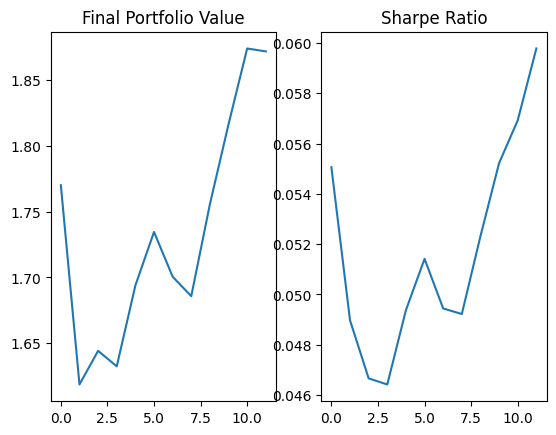

In [35]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(list(map(lambda d: d['port_val'][-1], log)))
axs[0].set_title('Final Portfolio Value')
axs[1].plot(list(map(lambda d: np.mean(np.array(d['port_val'][1:]) - np.array(d['port_val'][:-1])) / np.std(np.array(d['port_val'][1:]) - np.array(d['port_val'][:-1])), log)))
axs[1].set_title('Sharpe Ratio')
plt.show()